In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from fuzzywuzzy import process

c:\Coding\Python-Henrik-Pedersen-OPA2023\venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [106]:
#Add a flush

df_movies = None
df_ratings = None
df_ratings_filt = None
df_filtered = None
df_movies_filtered = None
df_combined = None

In [108]:
df_movies = pd.read_csv("data/movies.csv", usecols=["movieId", "title", "genres"], dtype={
                        "movieId": "int32", "title": "str", "genres": "str"})

df_ratings = pd.read_csv("data/ratings.csv", dtype={"userId": "int32", "movieId": "int32", "rating": "float32"})

In [74]:
df_combined = pd.merge(df_ratings, df_movies, on="movieId", how="inner")

In [109]:
min_ratings_per_movie = 500
filter_movies = df_combined["movieId"].value_counts() >= min_ratings_per_movie
filter_movies = filter_movies[filter_movies].index
df_filtered = df_combined[df_combined["movieId"].isin(filter_movies)]

#Försökte göra om med hjälp från Richard men samma problem verkar kvarstå, men det är oklart hur relevant det är så jag fortsätter.
min_ratings_per_user = 150
filter_users = df_filtered["userId"].value_counts() >= min_ratings_per_user
filter_users = filter_users[filter_users].index
df_filtered = df_filtered[df_filtered["userId"].isin(filter_users)]
df_filtered

TypeError: 'NoneType' object is not subscriptable

In [92]:
movie_counts = df_filtered["movieId"].value_counts()
print(movie_counts[movie_counts < min_ratings_per_movie])

movieId
85399     149
26124     149
26012     149
6939      149
771       149
         ... 
139148    125
3958      123
2865      117
1538      117
2776      103
Name: count, Length: 154, dtype: int64


# Labb 1 AI Machine learning advanced

Need to filter the data first since the dataset is 900mb. Looking for different ideas.

# EDA and plots!

In [78]:
df_combined

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,1225734739,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,110,4.0,1225865086,Braveheart (1995),Action|Drama|War
2,1,158,4.0,1225733503,Casper (1995),Adventure|Children
3,1,260,4.5,1225735204,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,1,356,5.0,1225735119,Forrest Gump (1994),Comedy|Drama|Romance|War
...,...,...,...,...,...,...
33832157,330975,8340,2.0,1091583256,Escape from Alcatraz (1979),Drama|Thriller
33832158,330975,8493,2.5,1091585709,Memphis Belle (1990),Action|Drama|War
33832159,330975,8622,4.0,1091581777,Fahrenheit 9/11 (2004),Documentary
33832160,330975,8665,3.0,1091581765,"Bourne Supremacy, The (2004)",Action|Crime|Thriller


In [79]:
print(df_combined.describe())

unique_movies = df_combined["movieId"].nunique()
unique_users = df_combined["userId"].nunique()
print(f"Number of unique movies: {unique_movies}")
print(f"Number of unique users: {unique_users}")

# Distribution of ratings
rating_counts = df_combined["rating"].value_counts().sort_index()
print(rating_counts)

# Most rated movies with movie titles
most_rated_movies_indices = df_combined["movieId"].value_counts().head(
    10).index
most_rated_movies = df_combined[df_combined["movieId"].isin(
    most_rated_movies_indices)]
most_rated_movies = most_rated_movies.groupby(
    "movieId")["title"].first()  # Get the movie title
print(most_rated_movies)

# Highest rated movies (with at least 300 ratings), including movie titles and genres
average_ratings = df_combined.groupby(
    "movieId")["rating"].agg(["mean", "count"])
average_ratings = average_ratings[average_ratings["count"] >= 300]
highest_rated_movies_indices = average_ratings.sort_values(
    by="mean", ascending=False).head(10).index
highest_rated_movies = df_combined[df_combined["movieId"].isin(highest_rated_movies_indices)][[
    "movieId", "title", "genres"]].drop_duplicates().set_index("movieId")
highest_rated_movies["average_rating"] = average_ratings["mean"]
print(highest_rated_movies.sort_values(by="average_rating", ascending=False))

# Ratings per user
ratings_per_user = df_combined["userId"].value_counts()
print(ratings_per_user.describe())

             userId       movieId        rating     timestamp
count  3.383216e+07  3.383216e+07  3.383216e+07  3.383216e+07
mean   1.654380e+05  2.831348e+04  3.542545e+00  1.269362e+09
std    9.534122e+04  4.992865e+04  1.063959e+00  2.541023e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    8.295300e+04  1.219000e+03  3.000000e+00  1.046718e+09
50%    1.661290e+05  3.263000e+03  4.000000e+00  1.264740e+09
75%    2.474500e+05  4.049100e+04  4.000000e+00  1.496919e+09
max    3.309750e+05  2.889830e+05  5.000000e+00  1.689843e+09
Number of unique movies: 83239
Number of unique users: 330975
rating
0.5     566306
1.0    1013645
1.5     562409
2.0    2146492
2.5    1760733
3.0    6400664
3.5    4465001
4.0    8835955
4.5    3123055
5.0    4957902
Name: count, dtype: int64
movieId
260             Star Wars: Episode IV - A New Hope (1977)
296                                   Pulp Fiction (1994)
318                      Shawshank Redemption, The (1994)
356            

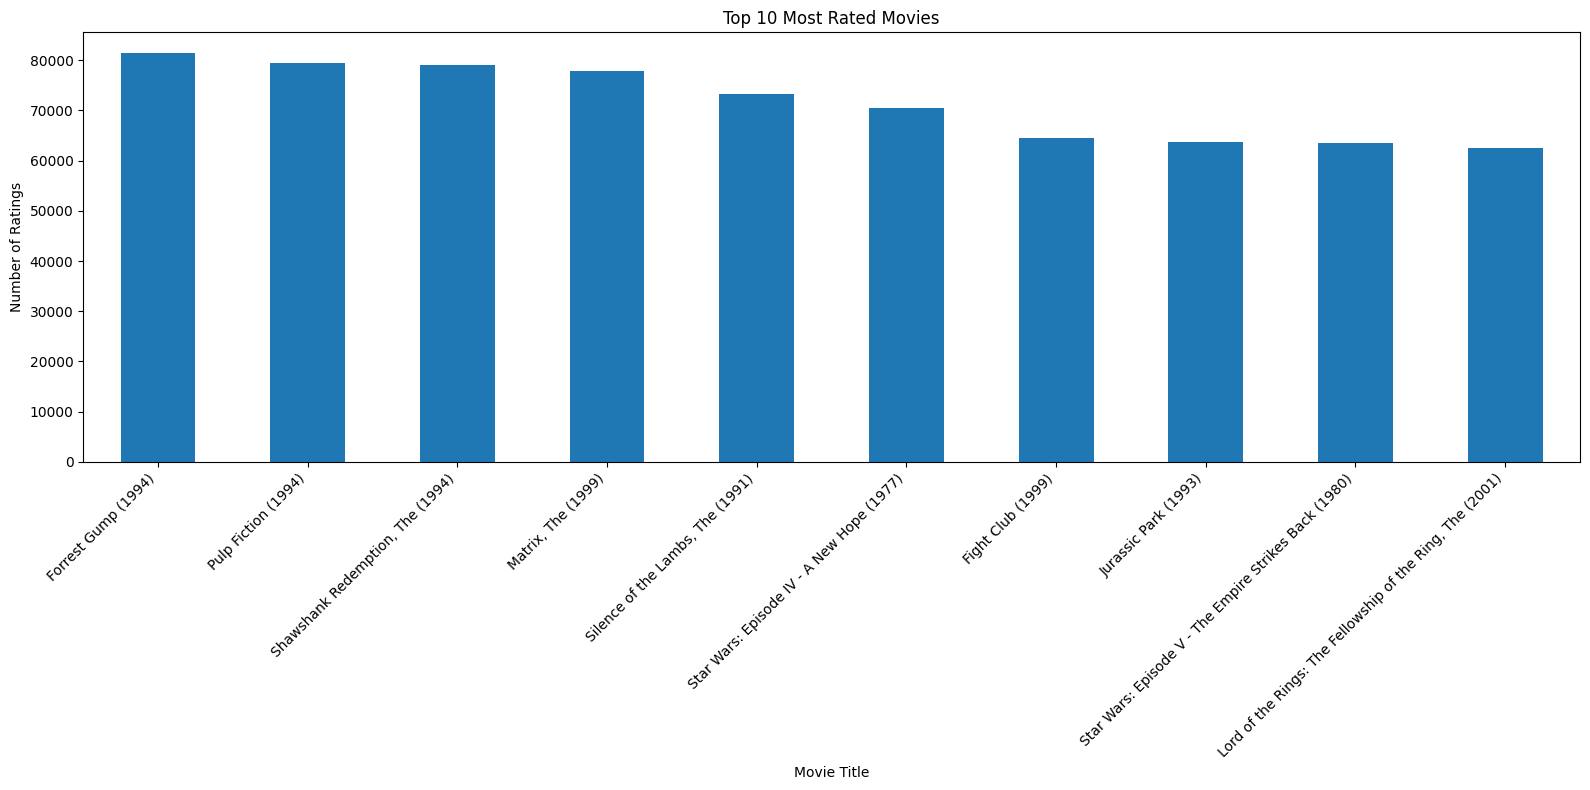

In [32]:
most_rated_movie_ids = df_combined["movieId"].value_counts().head(10).index

most_rated_movies = df_combined[df_combined["movieId"].isin(
    most_rated_movie_ids)]
most_rated_movies = most_rated_movies.groupby("movieId").first()["title"]

rating_counts = df_combined["movieId"].value_counts().loc[most_rated_movie_ids]

# Reorder the titles to match the rating_counts order
ordered_titles = most_rated_movies.reindex(rating_counts.index)

plt.figure(figsize=(16, 8))
rating_counts.plot(kind="bar")
plt.title("Top 10 Most Rated Movies")
plt.xticks(range(len(ordered_titles)), ordered_titles, rotation=45,
           ha="right")  # Set the x-ticks to be the movie titles
plt.xlabel("Movie Title")
plt.ylabel("Number of Ratings")
plt.tight_layout()  # Adjust layout
plt.show()

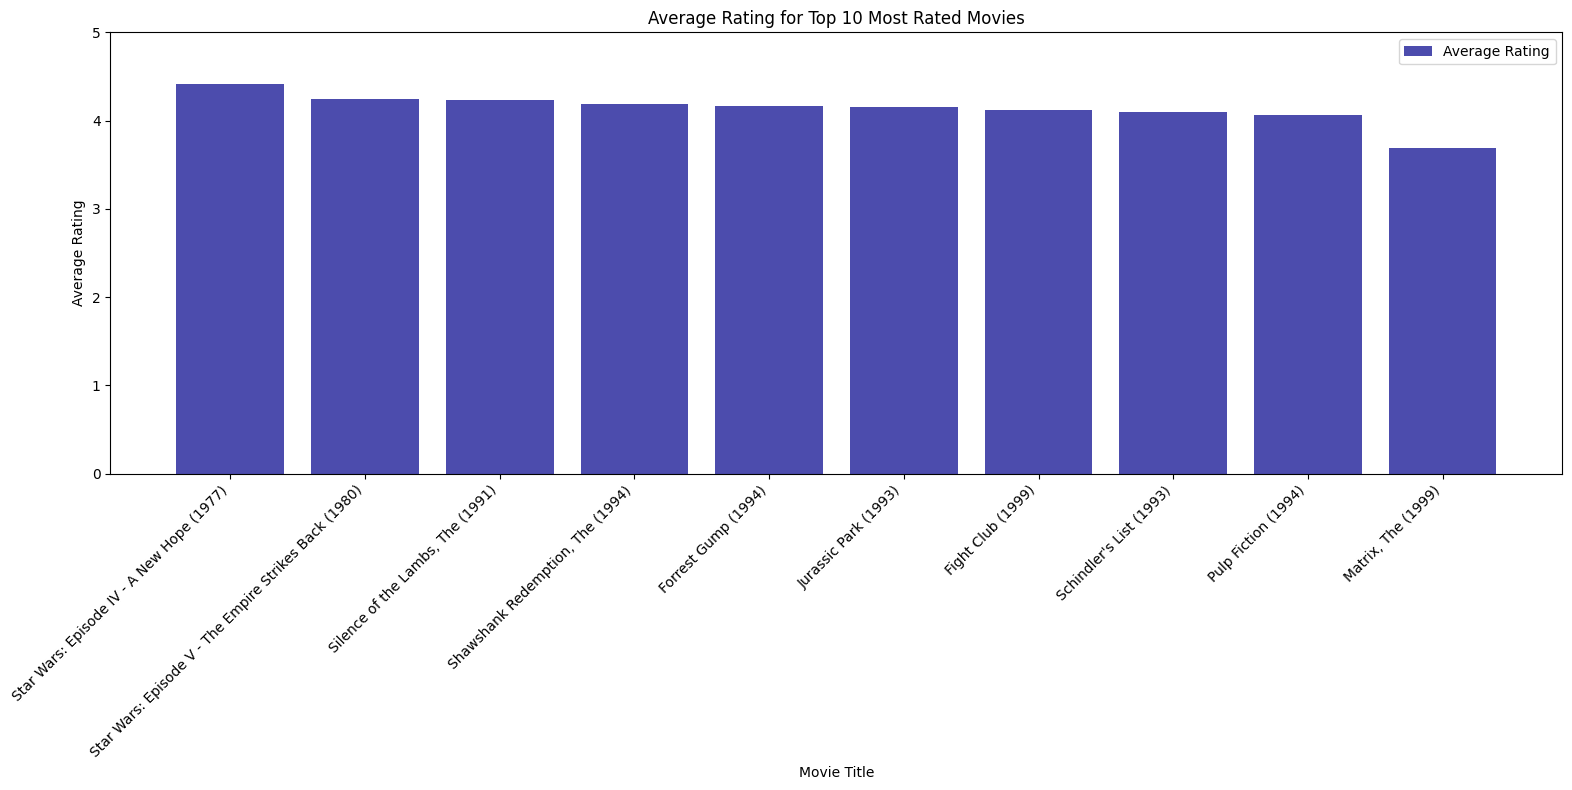

In [80]:
most_rated_movie_ids = df_combined["movieId"].value_counts().head(10).index

most_rated_movies = df_combined[df_combined["movieId"].isin(
    most_rated_movie_ids)]

most_rated_movies = most_rated_movies.groupby("movieId").first()["title"]
average_ratings = df_combined.groupby(
    "movieId")["rating"].mean().loc[most_rated_movie_ids]

most_rated_movies, average_ratings = zip(
    *sorted(zip(most_rated_movies, average_ratings), key=lambda x: x[1], reverse=True))


plt.figure(figsize=(16, 8))

plt.bar(range(len(most_rated_movies)), average_ratings,
        color='darkblue', alpha=0.7, label='Average Rating')

plt.xticks(range(len(most_rated_movies)),
           most_rated_movies, rotation=45, ha="right")
plt.xlabel("Movie Title")
plt.ylabel("Average Rating")
plt.title("Average Rating for Top 10 Most Rated Movies")
plt.ylim(0, 5) 
plt.legend()
plt.tight_layout()
plt.show()

The year release year is in the title, so i i will just slice out the last part and work from there.

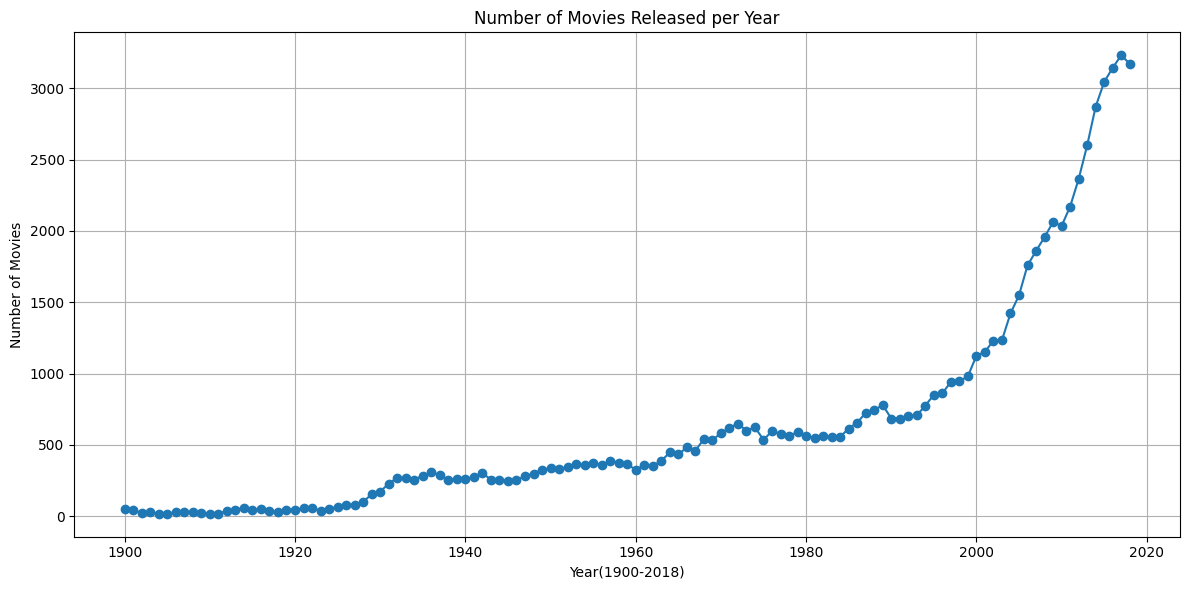

In [81]:
release_years = df_movies['title'].str[-5:-1]   #Just slice out the last part and use it.


release_years = release_years.str.extract('(\d+)').astype(float)    #Gippity

release_years = release_years[(
    release_years >= 1900) & (release_years <= 2018)]

movies_per_year = release_years[0].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(movies_per_year.index, movies_per_year.values,
         marker='o', linestyle='-')
plt.title('Number of Movies Released per Year')
plt.xlabel('Year(1900-2018)')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.tight_layout()
plt.show()

# Sparse Matrix

In [93]:
def create_sparse_matrix(df_combined):

    user_mapper = dict(zip(np.unique(df_combined["userId"]), list(range(df_combined["userId"].nunique()))))
    movie_mapper = dict(zip(np.unique(df_combined["movieId"]), list(range(df_combined["movieId"].nunique()))))


    user_inv_mapper = dict(zip(list(range(df_combined["userId"].nunique())), np.unique(df_combined["userId"])))

    movie_inv_mapper = dict(zip(list(range(df_combined["movieId"].nunique())), np.unique(df_combined["movieId"])))

    user_index = [user_mapper[i] for i in df_combined["userId"]]
    movie_index = [movie_mapper[i] for i in df_combined["movieId"]]

    sparse_matrix = csr_matrix((df_combined["rating"], (user_index, movie_index)), shape=(

        df_combined["userId"].nunique(), df_combined["movieId"].nunique()))
    
    return sparse_matrix, user_mapper, user_inv_mapper, movie_mapper, movie_inv_mapper


sparse_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse_matrix(
    df_combined)

In [94]:
sparse_matrix.shape
#User/Movies

(330975, 83239)

In [95]:
n_total = sparse_matrix.shape[0]*sparse_matrix.shape[1]
n_ratings = sparse_matrix.nnz

sparsity = n_ratings/n_total

print(f"Matrix Sparcity:{round(sparsity*100,2)}% ")

Matrix Sparcity:0.12% 


In [96]:
n_ratings_per_user = sparse_matrix.getnnz(axis=1)

len(n_ratings_per_user)

330975

In [97]:
n_ratings_per_user.max()

33332

In [98]:
n_ratings_per_user.min()

1

In [99]:
n_ratings_per_user.mean()

102.21969030893572

In [100]:
print("Unique Movie IDs in Dataset:")
print(df_movies['movieId'].unique())

Unique Movie IDs in Dataset:
[     1      2      3 ... 288975 288977 288983]


In [101]:
print("Unique Movie IDs in Dataset:")
print(df_combined['movieId'].unique())

Unique Movie IDs in Dataset:
[     1    110    158 ... 228179 261553 269782]


In [102]:
print("Sparse Matrix Dimensions:", sparse_matrix.shape)

Sparse Matrix Dimensions: (330975, 83239)


C:\Users\Delic\AppData\Local\Temp\ipykernel_13600\1103078765.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
C:\Users\Delic\AppData\Local\Temp\ipykernel_13600\1103078765.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)


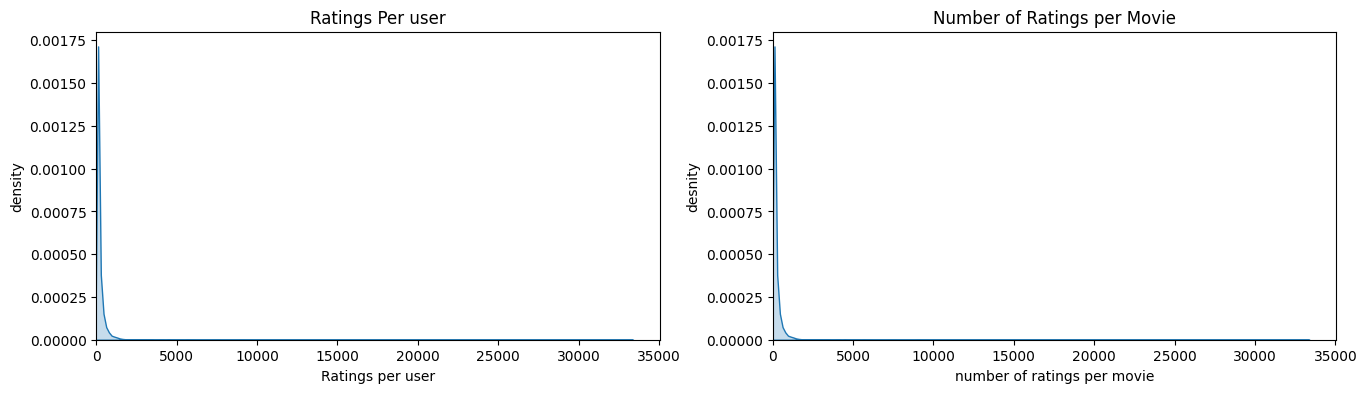

In [103]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Ratings Per user")
plt.xlabel("Ratings per user")
plt.ylabel("density")

plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)

plt.title("Number of Ratings per Movie")
plt.xlabel("number of ratings per movie")

plt.ylabel("desnity")
plt.show()

In [104]:
def build_knn_model(sparse_matrix):
    # Initialize the KNN model
    knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
    # Fit the model to the sparse matrix
    knn_model.fit(sparse_matrix)
    return knn_model


knn_model = build_knn_model(sparse_matrix)

In [105]:
def find_similar_movies(movie_id, k=5):
    # Find the index of the movie in the sparse matrix
    movie_index = movie_mapper.get(movie_id)
    if movie_index is None:
        print(f"Movie ID {movie_id} not found in the mapper.")
        return []

    # Find k nearest neighbors for the given movie
    distances, indices = knn_model.kneighbors(
        sparse_matrix[movie_index], n_neighbors=k+1)

    # Exclude the first neighbor as it will be the movie itself
    similar_movies = []
    for i, idx in enumerate(indices.flatten()[1:]):
        if idx in movie_inv_mapper:
            movie_id = movie_inv_mapper[idx]
            similarity = 1 - distances[0, i]
            similar_movies.append((movie_id, similarity))
        else:
            print(f"Movie ID {idx} not found in the inverse mapper.")

    return similar_movies


# Example: Find similar movies to a given movie (movieId=1)
similar_movies = find_similar_movies(3)
print("Similar movies to 'Toy Story (1995)':")
for movie_id, similarity in similar_movies:
    movie_title = df_movies[df_movies['movieId']
                            == movie_id]['title'].values[0]
    print(f"{movie_title} (ID: {movie_id}), Similarity: {similarity:.2f}")

Movie ID 102338 not found in the inverse mapper.
Movie ID 108025 not found in the inverse mapper.
Movie ID 274638 not found in the inverse mapper.
Similar movies to 'Toy Story (1995)':
Merry In-Laws (2012) (ID: 165303), Similarity: 0.43
Warning for the Joensson Gang (Varning för Jönssonligan) (1981) (ID: 5913), Similarity: 0.43
